<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [100]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

from scipy.stats import beta  


In [39]:
# datos

cats = pd.read_csv('/Users/lcorrea/Documents/GitHub/6.4_lab-AB-Testing/data/cookie_cats.csv')
cats.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [40]:
repe = cats.groupby(by ='userid').version.value_counts()

In [41]:
repe[repe > 1] #no hay repetidos.

Series([], Name: version, dtype: int64)

In [53]:
# transformacion

cats.groupby(by = 'version').retention_1.value_counts()


version  retention_1
gate_30  False          24666
         True           20034
gate_40  False          25370
         True           20119
Name: retention_1, dtype: int64

In [54]:
cats.groupby(by = 'version').retention_7.value_counts()

version  retention_7
gate_30  False          36198
         True            8502
gate_40  False          37210
         True            8279
Name: retention_7, dtype: int64

False    25370
True     20119
Name: retention_1, dtype: int64

In [47]:
cats.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [3]:
# muestreo



In [51]:
# testeo para retention_1

g_30_ctrl, ret_ctrl_1 = 44700, 20034

g_40_ctrl, ret_test = 45489,20119


In [52]:
control_g30 = ret_ctrl_1/g_30_ctrl

test_g40 = ret_test/g_40_ctrl


control_g30,test_g40

(0.4481879194630872, 0.44228274967574577)

In [83]:
# testeo para retention_7

g_30_ctrl_7,ret_ctrl_7 =  44700,8502

g_40_test_7, ret_test_7 = 45489,8279




In [85]:
control_g30_7 = ret_ctrl_7/g_30_ctrl_7

test_g40_7 = ret_test_7/g_40_test_7


control_g30_7,test_g40_7

(0.19020134228187918, 0.18200004396667327)

In [97]:

a_C, b_C = ret_ctrl_7+1, g_30_ctrl_7-ret_ctrl_7+1
a_T, b_T = ret_test_7+1, g_40_test_7-ret_test_7+1

beta_control=beta(a_C, b_C)
beta_test=beta(a_T, b_T)
beta_control.mean(),beta_test.mean()

(0.19021520289919913, 0.18201402475214878)

In [115]:
x=np.linspace(0.17, 0.20, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

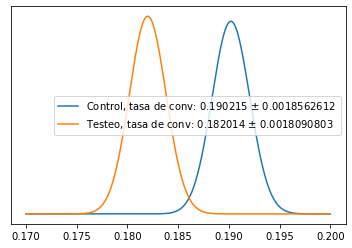

In [116]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [133]:

a_c, b_c = ret_ctrl_1+1, g_30_ctrl-ret_ctrl_1+1
a_t, b_t = ret_test+1, g_40_ctrl-ret_test+1

beta_control_1=beta(a_c, b_c)
beta_test_1=beta(a_t, b_t)
beta_control_1.mean(),beta_test_1.mean()

(0.44819023757326293, 0.44228528719966587)

In [113]:
x=np.linspace(0.42, 0.47, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

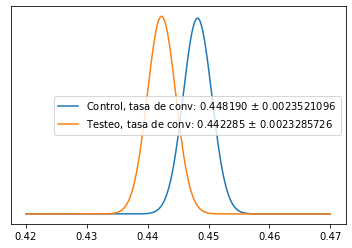

In [114]:
plot([beta_control_1, beta_test_1], ['Control', 'Testeo'])

In [119]:
salto_7=(beta_test.mean() - beta_control.mean())/beta_control.mean()

salto_7

-0.04311526114658881

In [167]:
salto_1=(beta_test_1.mean() - beta_control_1.mean())/beta_control_1.mean()

salto_1

-0.013175098158249857

In [168]:
beta.cdf(0.445,a_t,b_t)   #sitio de corte #el profe lo hizo con otra
prob=beta.cdf(0.445,a_t,b_t) #el area del test del punto de corte
prob=float(prob)

In [169]:
#retencion dia 1

prob

0.8781293616836622

In [161]:
beta.cdf(0.186,a_T,b_T)   #sitio de corte #el profe lo hizo con otra
prob=beta.cdf(0.186,a_T,b_T) #el area del test del punto de corte
prob_7=float(prob)

In [162]:
# retencion dia 7 

prob_7

0.9858653005312228

In [164]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.


'''El test retencion 7 aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto_7*100, prob_7*100)


'El test retencionn 7 aumenta la tasa de conversion en un -4.31%, con una probabilidad del 98.59%'

In [170]:
'''El test retencion 1 aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto_1*100, prob*100)


'El test retencion 1 aumenta la tasa de conversion en un -1.32%, con una probabilidad del 87.81%'

In [ ]:
'''El test retencion 7 disminuye mucho mas que el retencion 1'''


